### This notebook should:
- collect total number of signal events remaining post-isaura
- see how many will be lost to the non-topological cuts (fiducial, energy)
- quantify how many tracks are then lost due to track mis-reco.
  - how many signal events are mis-reco'd?
  - where are they lost? blob overlap? 1 track? etc

In [1]:
import sys,os,os.path
sys.path.append("/gluster/data/next/software/IC_satkill/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
#sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/gluster/data/next/software/IC_satkill/'


import traceback

import os
import sys
import random
from tqdm import tqdm
import tables as tb
import numpy  as np
import pandas as pd
import scipy.spatial.distance as scidist
import invisible_cities.core.fit_functions  as fitf
from   invisible_cities.core.stat_functions import poisson_sigma
import invisible_cities.reco.dst_functions  as dstf
from   invisible_cities.core.core_functions import shift_to_bin_centers
from invisible_cities.core.testing_utils import assert_hit_equality
from IC.invisible_cities.reco.paolina_functions import voxelize_hits, drop_end_point_voxels, make_track_graphs, get_track_energy
# hack to avoid QhullError
from scipy.spatial.qhull import QhullError
from scipy import spatial
spatial.QhullError = QhullError
#from  skimage.morphology import skeletonize_3d

from invisible_cities.evm                  import event_model as evm
from invisible_cities.evm  .event_model    import Cluster, Hit
from invisible_cities.types.ic_types       import xy
from invisible_cities.reco import paolina_functions    as plf

from invisible_cities.io.dst_io import load_dst
import invisible_cities.io.mcinfo_io as mcio

import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.patheffects as PathEffects
import matplotlib.lines as mlines


#import core.functions as func

import imageio

In [2]:


def add_binclass(mchits, mcpart, signal_creator = 'conv'):
    '''
    Adds binary class to each hit depending on if its event is considered as signal or background.
    The two possible classes for the events are:
        0 - background
        1 - signal
    Process:
        - Selects particles that had any hit in the active.
        - Selects only e-/e+
        - If there are 2 particles in an event that are created by a certain process,
          labels the event as signal. 
        - Otherwise, as background.
    For double escape data, the creator process is signal_creator = 'conv' (i.e. 208Tl data).
    For 0nubb data, the creator process is signal_creator = 'none'.

    Args:
        mchits: DATAFRAME
    Contains the MC hits information of every event in a file, from table MC/hits.
        mcpart: DATAFRAME
    Contains the MC particles information for every event in a file, from table MC/particles.
        signal_creator: STR
    If 'conv', signal will be the double escape data.
    If 'none', signal will be the neutrinoless decay data.
    
    RETURNS:
        mchits_binclass: DATAFRAME
    The mchits df with a new column containing the binclass.
    '''

    # Select only those particles that actually left any hit in the active
    hits_part = pd.merge(mchits, mcpart, on = ['event_id', 'particle_id'])
    hits_part = hits_part[mcpart.columns].drop_duplicates()

    # Select e+/e-
    hits_part = hits_part[np.isin(hits_part.particle_name, ['e+', 'e-'])]
    
    # Create a selector of signal/background
    selector = lambda x: 1 if int(sum(x == signal_creator)) == 2 else 0

    class_label = hits_part.groupby('event_id').creator_proc.apply(selector).astype(int)
    class_label.name = 'binclass'
    mchits_binclass  = pd.merge(mchits, class_label, on = 'event_id')
    
    return mchits_binclass

def get_extremes(file, signal_creator = 'conv'):
    '''
    Gets the extremes of the MC track. 
    It also gives them a label, called 'ext', which can be:
        1 - end   of background track, random for signal track
        2 - start of background track, random for signal track (for similarity with 'blob2')
    Process:
        - Do binary classification of the events
        - Select the main particles in the event (e+e- or e-e- for signal,
          the most energetic e- for background)
        - Select the extremes (last hits for signal, first/last for background)
    
    Args:
        file: STR
    Path to any file with MC information.
        signal_creator: STR
    If 'conv', signal will be the double scape data.
    If 'none', signal will be the neutrinoless decay data.
    
    RETURNS:
        track_ext: DATAFRAME
    The extreme hits of each event with a label.
    '''

    mcpart = load_dst(file, 'MC', 'particles')
    mchits = load_dst(file, 'MC', 'hits')
    mchits = mchits[mchits.label == 'ACTIVE']
    
    # Add binclass label to the hits
    mchits_label = add_binclass(mchits, mcpart, signal_creator = signal_creator)
    # Add to each hit the particle information
    hits_part = pd.merge(mchits_label, mcpart, on = ['event_id', 'particle_id'])
    # Do the sum on the energy so we can choose the most energetic e- in a bkg event
    per_part_info = hits_part.groupby(['event_id',
                                        'particle_id',
                                        'particle_name',
                                        'binclass',
                                        'creator_proc']).agg({'energy':[('track_ener', sum)], 'hit_id':[('nhits', len)]})
    per_part_info.columns = per_part_info.columns.get_level_values(1)
    per_part_info.reset_index(inplace=True)

    # Select each type of particle
    ## Signal
    particles_sig = per_part_info[(per_part_info.binclass == 1) &\
                                    np.isin(per_part_info.particle_name, ['e+', 'e-']) &\
                                    (per_part_info.creator_proc == signal_creator)]
    ## Background
    particles_bkg = per_part_info[(per_part_info.binclass == 0) &\
                                    (per_part_info.particle_name == 'e-') &\
                                    (per_part_info.creator_proc.isin(['compt', 'phot', 'none']))]

    particles_bkg = particles_bkg.loc[particles_bkg.groupby('event_id').track_ener.idxmax()]

    # Search for the extremes
    ## Signal
    hits_sig = pd.merge(mchits_label, particles_sig)
    track_ext_sig = hits_sig.groupby(['event_id', 'particle_id']).apply(lambda x: x.loc[x['hit_id'].idxmax()]).reset_index(drop = True)
    track_ext_sig['ext'] = track_ext_sig.groupby('event_id').cumcount() + 1

    ## Background
    hits_bkg = pd.merge(mchits_label, particles_bkg)

    track_start_bkg = hits_bkg.groupby(['event_id', 'particle_id']).apply(lambda x: x.loc[x['hit_id'].idxmin()]).reset_index(drop=True)
    track_end_bkg   = hits_bkg.groupby(['event_id', 'particle_id']).apply(lambda x: x.loc[x['hit_id'].idxmax()]).reset_index(drop=True)

    ### asigned this label so 2 is like "blob2" 
    track_start_bkg['ext'] = 2
    track_end_bkg['ext']   = 1

    # Join all
    track_ext_bkg = pd.concat([track_start_bkg, track_end_bkg])
    track_ext = pd.concat([track_ext_bkg, track_ext_sig]).sort_values('event_id')
    return track_ext


def blob_accuracy(mc_extremes, isaura_data):
    '''
    for a specific event, compare pairwise and select the shortest distances from each blob
    (this technically could work incorrectly, but lets hope not)

    just pass through the mc_extremes table produced in martins function, and the isaura dataframe
    each for the specific event
    '''

    # collect extrema positions
    extremes = []
    for blob, dfext in mc_extremes.groupby('ext'):
        extremes.append([dfext.x.values[0], dfext.y.values[0], dfext.z.values[0]])

    extremes = np.array(extremes)

    # collect blob positions
    b1 = np.array([isaura_data.blob1_x.values[0], isaura_data.blob1_y.values[0], isaura_data.blob1_z.values[0]])
    b2 = np.array([isaura_data.blob2_x.values[0], isaura_data.blob2_y.values[0], isaura_data.blob2_z.values[0]])

    # calculate distance between blob 1 in isaura and the MC info
    b1_xyz = b1 - extremes
    magn1 = np.linalg.norm(b1_xyz[:2], axis = 1)

    # if first magnitude is smaller, calculate b2 with second, and vice versa
    if magn1[0] < magn1[1]:
        b2_xyz = b2 - extremes[1]
        magn2 = np.linalg.norm(b2_xyz[:2])
        magn1 = magn1[0]
        b1_xyz = b1_xyz[0]
        # collect x_reco - x_true, for xyz
    elif magn1[0] > magn1[1]:
        b2_xyz = b2 - extremes[0]
        magn2 = np.linalg.norm(b2_xyz[:2])
        magn1 = magn1[1]
        b1_xyz = b1_xyz[1]
    else:
        RuntimeError("magnitudes are either identical or broken, very weird case!")

    # return 'reco - true' for blob position in magnitude terms
    return ([magn1, magn2, b1_xyz, b2_xyz])

In [3]:
'''
create a function that:
- reads in dataframes of importance
    - mcio hits
    - mc particle information
    - isaura tracking information
- determines blob accuracy
- adds it to dataframe with blob accuracy, z_average
- repeats for new files (to not overload network)
'''

def collate_blob_data(folder_path, MC_source):
    # collect all the file names
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.h5')]

    blob_info = pd.DataFrame(columns = ['Event', 'blob1_magnitude', 'blob2_magnitude', 'b1_xyz', 'b2_xyz', 'z_ave'])
    
    dead_evts = []
    
    #try:
    for file in tqdm(file_names):
        file_path = folder_path + file

        # Collect data
        tracking = pd.read_hdf(file_path, 'Tracking/Tracks')

        dfMC = mcio.load_mchits_df(MC_source + file).reset_index()
        infoMC = pd.read_hdf(MC_source + file, 'MC/particles')
        eventsMC = np.unique(dfMC.event_id.to_numpy())

        # Collect extremes
        mc_extr = get_extremes(MC_source + file)

        # placeholder
        rows = []

        # event by event collect blob extremes
        for evt, dfs in tracking.groupby('event'):

            try:
                # collect most energetic track
                energetic_track = dfs[dfs.trackID == 0]
                extr = mc_extr[mc_extr.event_id == evt//2]

                holding = blob_accuracy(extr, energetic_track)
                rows.append({'Event': evt, 'blob1_magnitude': holding[0], 'blob2_magnitude': holding[1], 'b1_xyz': holding[2], 'b2_xyz': holding[3], 'z_ave': energetic_track.z_ave.to_numpy()[0]})
            except:
                print(f"Broke at: {file}\nEvent (MC): {evt} ({evt//2})")
                # this is assuming that some data broke
                dead_evts.append(evt)
                rows.append({'Event': evt, 'blob1_magnitude': 99999, 'blob2_magnitude': 99999, 'b1_xyz': [99999, 99999, 99999], 'b2_xyz': [99999, 99999, 99999], 'z_ave': 99999})
                continue
        blob_info = pd.concat([blob_info, pd.DataFrame(rows)], ignore_index = True)
    #except Exception as e:
    #    print(f"Broke at: {file}\nEvent (MC): {evt} ({evt//2})")
    #    #display(dfMC)
    #    #display(dfMC[dfMC])
    #    display(mc_extr)
    #    display(mc_extr[mc_extr.event_id == evt//2])
    #    print(extr)
    #    traceback.print_exc()
    return blob_info

### ALL THE RELEVANT CUTTING FUNCTIONS


In [4]:


def energy_cuts(df, lower_e = 1.5, upper_e = 1.7, verbose = False, ID = 'event'):
    '''
    Remove all events outwith the relevant energy values

    Args:
        df              :           pandas dataframe
        lower_e         :           lower bound for energy
        upper_e         :           upper bound for energy
        verbose         :           verbose boolean
    
    Returns:
        filt_e_df       :           cut dataframe
    '''
    filt_e_df = (df[(df['energy'] >= lower_e) & (df['energy'] <= upper_e)])[ID].unique()
   
    

    if (verbose == True):
        print("Cutting energy events around {} & {} keV".format(lower_e, upper_e))

    return df[df[ID].isin(filt_e_df)]
    


def one_track_cuts(df, verbose = False, ID = 'event'):
    '''
    Remove events with more than one track from dataframe
    There is a better way of doing this, using a column within the dataframe.

    Args:
        df                  :               pandas dataframe
        verbose             :               verbose boolean

    Returns:
        one_track_events    :               cut dataframe

    '''
    # 1-track event counter
    event_counts = df.groupby(ID).size()
    #print(event_counts[:5]) # showing that you see how many 
                            #  trackIDs there are per event
    one_track = event_counts[event_counts == 1].index

    # filter dataframe
    one_track_events = df[df[ID].isin(one_track)]
    

    if (verbose == True):
        print("Removing events with more than one track.")
        print("Events with one track: {}".format(one_track))
        display(one_track_events.head())
    

    return one_track_events



def overlapping_cuts(df, verbose = False):
    '''
    Remove all events with blobs of overlapping energy != 0

    Args:
        df              :               pandas dataframe
        verbose         :               verbose boolean

    Returns:
        ovlp_remove     :               cut dataframe
    '''

    ovlp_remove = df[df['ovlp_blob_energy']==0]

    if (verbose==True):
        print("Removing overlapping blobs...")

    return ovlp_remove


def fiducial_track_cut_2(df, lower_z = 20, upper_z = 1195, r_lim = 472, verbose = False, ID = 'event'):
    '''
    Remove events outwith the defined fiducial volume.

    Args:
        df          :           pandas dataframe
        lower_z     :           lower z-bound for fiducial cut
        upper_z     :           upper z-bound for fiducial cut
        r_lim       :           radial bound for fiducial cut
        verbose     :           verbose boolean

    Returns:
        df3         :           cut dataframe
    '''
    # create lists of outer_fiduc entries
    z_df_low = df[(df['z_min'] <= lower_z)]
    z_df_up = df[(df['z_max'] >= upper_z)]
    r_df = df[(df['r_max'] >= r_lim)]

    # scrape the events
    low_list = (z_df_low[ID].to_numpy())
    up_list = (z_df_up[ID].to_numpy())
    r_list = (r_df[ID].to_numpy())

    # apply the filter to remove all events that fall in outer fiduc
    df1 = df[~df[ID].isin(low_list)]
    df2 = df1[~df1[ID].isin(up_list)]
    df3 = df2[~df2[ID].isin(r_list)]

    if (verbose == True):
        print("Cutting events around fiducial volume related to:\nZ range between {} and {}\nRadius range < {}".format(lower_z, upper_z, r_lim))


    return df3


def count_tracks_mc(hits_deco):
   
    # stuff needed for paolina track counting
    energy_threshold = 10
    min_voxels = 3
    
    base_vsize = 12 #mm
    the_hits = []

    xs = hits_deco.x
    ys = hits_deco.y
    zs = hits_deco.z
    es = hits_deco.energy

    for x, y, z, e in zip(xs, ys, zs, es):
        if np.isnan(e): continue
        h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
        the_hits.append(h)

    voxels = voxelize_hits(the_hits,
                           np.array([base_vsize, base_vsize, base_vsize]), False)

    (mod_voxels, dropped_voxels) = drop_end_point_voxels(voxels, energy_threshold, min_voxels)

    
    tracks = make_track_graphs(mod_voxels)
    tracks = sorted(tracks, key=get_track_energy, reverse = True)
    
    track_no = 0
    for c, t in enumerate(tracks, 0):
        track_no += 1
    
    return track_no    


### Collect all the signal events

we'll look at port 1a for the moment

In [5]:
posi_dir = '/gluster/data/next/notebooks/john_books/soph_df_data/'
true_info_labels = ['1a_Tl_signal_true_info.h5']


pos_events = []

for i in range(len(true_info_labels)):
    port_id = true_info_labels[i][:2]
    data_posi = pd.read_hdf(posi_dir + true_info_labels[i])
    data_posi['PORT'] = str(port_id)
    if (i == 0):
        pos_events.append(data_posi)
    else:
        # alter the event numbers
        pos_events.append(data_posi)
    
    print(f'Positron events in {port_id}: {data_posi.event_id.nunique()}')
    
pos_events = pd.concat(pos_events, axis = 0, ignore_index = True)
# double to match the tracking info
pos_events.event_id = pos_events['event_id']*2


display(pos_events)
print(pos_events.event_id.unique())

Positron events in 1a: 6175


,event_id,particle_id,hit_id,x,y,z,time,energy,label,PORT
0,16,52,0,315.166870,208.526917,731.868896,1.128019,0.000005,ACTIVE,1a
1,16,51,0,315.680695,208.035660,732.565308,0.961651,0.001719,ACTIVE,1a
2,16,51,1,316.120941,207.520065,733.248108,0.965438,0.001694,ACTIVE,1a
3,16,51,2,316.652252,206.863007,733.708008,0.969227,0.000674,ACTIVE,1a
4,16,51,3,316.177185,206.028381,733.763306,0.973017,0.004037,ACTIVE,1a
...,...,...,...,...,...,...,...,...,...,...
3415856,5800580,45,30,112.188820,95.269257,618.456299,1.479308,0.000619,ACTIVE,1a
3415857,5800580,45,31,112.198914,95.268547,618.448975,1.479575,0.001096,ACTIVE,1a
3415858,5800580,45,32,112.202179,95.277473,618.447754,1.479800,0.002352,ACTIVE,1a
3415859,5800580,45,33,112.203796,95.279572,618.450989,1.479932,0.001731,ACTIVE,1a


[16 64 66 ... 5800550 5800552 5800580]


### Read in the isaura data

In [6]:
#folder_path = '/gluster/data/next/files/TOPOLOGY_John/fifteen_mm_pitch/PORT_1a/isaura/'
folder_path = '/gluster/data/next/files/TOPOLOGY_John/HYPPOS_DATA_QTHR/BEERSHEBA_STUDY/e_cut/blobR_voxelS/b27v9/PORT_1a/isaura/'
#folder_path = '/gluster/data/next/files/TOPOLOGY_John/HYPPOS_DATA_QTHR/BEERSHEBA_STUDY/e_cut/rel_0.2_new/PORT_1a/isaura/'


flag = False
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.h5')]
for file in tqdm(file_names):
    # first loop, create df
    if flag == False:
        file_path = folder_path + file
        tracking = pd.read_hdf(file_path, 'Tracking/Tracks')
        flag = True
    else:
        file_path = folder_path + file
        tracking_temp = pd.read_hdf(file_path, 'Tracking/Tracks')
        tracking = pd.concat([tracking, tracking_temp])

100%|██████████| 300/300 [00:23<00:00, 12.99it/s]


In [7]:
display(tracking)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,0,0,0.430137,42.219578,36,4200,3,351.875,-207.425,773.807738,...,785.041687,392.553402,-193.996445,778.724004,0.325842,0.274363,0.170068,8.909091,8.938776,8.985429
1,0,1,0.100154,15.492306,7,718,3,253.875,-46.425,857.615981,...,862.386702,265.362191,-36.377118,868.992086,0.100154,0.100154,0.100154,8.909091,8.938776,8.985429
2,0,2,0.019781,15.492306,2,71,3,214.875,205.575,795.273675,...,801.389334,218.590523,211.170733,797.181647,0.019781,0.019781,0.019781,8.909091,8.938776,8.985429
3,2,0,2.199912,499.762729,351,21994,2,125.875,-95.425,505.002684,...,547.067286,291.968568,179.039013,529.855947,0.400130,0.067598,0.000000,8.681818,9.000000,8.834166
4,2,1,0.153573,21.186776,6,847,2,111.875,-121.425,401.142328,...,405.858757,133.016578,-115.886194,406.039125,0.153573,0.153573,0.153573,8.681818,9.000000,8.834166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,5920694,1,0.030119,8.857143,2,236,2,288.875,42.575,439.708205,...,442.645528,291.266048,52.333912,444.155380,0.030119,0.030119,0.030119,8.944444,8.857143,8.908697
652,5920696,0,0.453068,66.868719,47,3268,2,381.875,169.575,342.175706,...,362.245161,422.647641,219.934731,353.288354,0.333492,0.096012,0.000000,8.922078,8.818182,8.621201
653,5920696,1,0.203324,24.143409,11,795,2,-259.125,-148.425,168.151709,...,170.491284,-237.918062,-138.627129,183.350289,0.203324,0.203324,0.203324,8.922078,8.818182,8.621201
654,5920698,0,0.945283,301.891519,222,16402,1,-34.125,-462.425,793.675509,...,807.453501,139.338705,-457.182613,863.847534,0.093508,0.075538,0.000000,8.857143,8.960000,8.321476


In [8]:
# select only events in which events have positrons
pos_ids = pos_events['event_id'].unique()
sig_data = tracking[tracking['event'].isin(pos_ids)]
bck_data = tracking[~tracking['event'].isin(pos_ids)]

In [9]:
print("Number of signal data events with only one track")
display(sig_data[sig_data.numb_of_tracks == 1].nunique()[0])

#col_data = sig_data[sig_data.numb_of_tracks == 1]

# toggling this lets you see the effect of the lower cuts (before one track)
col_data = sig_data

Number of signal data events with only one track


2788

In [10]:
eregion_data = energy_cuts(col_data, lower_e = 1.5, upper_e = 1.7)
print("Number of signal data events in ROI")
display(eregion_data.nunique()[0])

Number of signal data events in ROI


3514

In [11]:
fidregion_data = fiducial_track_cut_2(eregion_data, lower_z = 20, upper_z = 1170, r_lim = 415)
print("Number of signal data in ROI & Fiducial Volume")
display(fidregion_data.nunique()[0])

Number of signal data in ROI & Fiducial Volume


1797

In [12]:
blobregion_data = overlapping_cuts(fidregion_data)
print("Number of signal data in ROI & Fiducial Volume w/out Overlapping blobs")
display(blobregion_data.nunique()[0])

Number of signal data in ROI & Fiducial Volume w/out Overlapping blobs


1797

In [13]:
onetrackregion_data = one_track_cuts(fidregion_data)
print("Number of signal data in ROI & Fiducial Volume w/ one track")
display(onetrackregion_data.nunique()[0])

Number of signal data in ROI & Fiducial Volume w/ one track


1137

### Checking that the events that dont pass one track here are actually messed up

In [14]:
# select events in blobregion_data but not onetrackregion_data. (cuts that fail the one track cut)
failed_onetrack_data = blobregion_data[~blobregion_data.event.isin(onetrackregion_data.event)]
display(failed_onetrack_data)
print("Number of signal events that fail one track cut post all other cuts")
display(failed_onetrack_data.nunique()[0])

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
267,272,0,1.590550,86.234067,120,11863,3,-47.125,-80.425,557.467838,...,564.577754,20.527146,-33.318350,584.857977,0.586264,0.340818,0.0,8.857143,8.952381,8.811110
426,418,0,1.607942,245.998179,203,15375,2,45.875,194.575,491.008744,...,496.089619,156.594789,336.700919,560.293623,0.414825,0.387448,0.0,8.957447,8.880000,8.425505
520,80540,0,1.527391,224.713924,222,13553,2,-82.125,-361.425,368.357489,...,372.830174,-72.368803,-211.066812,431.647028,0.468878,0.341963,0.0,8.333333,8.666667,8.570662
611,80634,0,1.572187,172.350587,174,11901,2,282.875,42.575,385.340583,...,443.417454,329.499229,118.343543,425.545513,0.365407,0.323670,0.0,8.428571,8.714286,8.527549
221,180236,0,1.558306,166.851439,168,10150,2,-370.125,-6.425,224.798470,...,266.009864,-364.660974,6.479674,249.080466,0.437583,0.386760,0.0,8.250000,8.937500,8.947238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,5840038,0,1.591360,205.624232,183,11623,6,202.875,44.575,365.437373,...,435.227045,208.259282,50.163885,401.067216,0.527678,0.447545,0.0,8.333333,8.777778,8.277099
182,5840178,0,1.591888,210.939661,264,18032,2,219.875,61.575,726.406078,...,869.100694,240.707547,65.051878,741.724266,0.482309,0.248579,0.0,8.500000,8.687500,8.708182
324,5840306,0,1.611512,158.768440,159,9627,2,15.875,-181.425,99.124750,...,101.585818,63.739801,-142.406207,198.683970,0.481713,0.170555,0.0,8.787879,8.857143,8.921597
200,5900222,0,1.590583,96.479448,187,16956,4,307.875,27.575,557.479847,...,579.303769,390.229937,101.847948,596.877984,0.202390,0.181194,0.0,8.916667,8.687500,8.430489


Number of signal events that fail one track cut post all other cuts


660

In [ ]:
tracked_ids = (failed_onetrack_data.event.unique())//2
tracked_hits = []
i = 0
# create MC particle information dataframe containing only events within these regions
for file in tqdm(file_names):
    i +=1
    pth = folder_path + file
    mcpart = load_dst(pth, 'MC', 'hits')
    #display(mcpart.event_id.unique())
    relevant_events = mcpart[mcpart.event_id.isin(tracked_ids)]
    tracked_hits.append(relevant_events)

tracked_hits = pd.concat(tracked_hits)

In [ ]:
tracked_info = []
# add track information to new df
for event, df in failed_onetrack_data.groupby('event'):
    # take the most energetic track (always the first)
    reco_track_num = df.iloc[0].numb_of_tracks
    
    
    MC_hits = tracked_hits[tracked_hits.event_id == event//2]
    MC_track_num = count_tracks_mc(MC_hits)
    
    r_minus_t = int(reco_track_num) - MC_track_num
    
    tracked_info.append([event, MC_track_num, int(reco_track_num), r_minus_t])
    
    
track_number_df = pd.DataFrame(tracked_info, columns = ['event', 'true_tracks', 'reco_tracks', 'reco-true'])

In [ ]:
# collect list of reco - true, and compare.
labels, counts = np.unique(track_number_df['reco-true'], return_counts=True)
plt.bar(labels, counts, align = 'center')
plt.title('Reco - true for tracks - events that fail one-track')
plt.xlabel('reco - true number')
plt.show()

### a quick check

first lets collect all the MC info on these

A quick check, does martins MC agree with mine?

In [ ]:
#folder_path = '/gluster/data/next/files/TOPOLOGY_John/fifteen_mm_pitch/PORT_1a/isaura/'

file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.h5')]
sb_labelled = []
for file in tqdm(file_names):
    pth = folder_path + file
    try:
        mcpart = load_dst(pth, 'MC', 'particles')
        mchits = load_dst(pth, 'MC', 'hits')
        mchits = mchits[mchits.label == 'ACTIVE']
    
        sb_labelled.append(add_binclass(mchits, mcpart, signal_creator = 'conv'))
    except:
        continue
    
sb_labelled = pd.concat(sb_labelled)
display(sb_labelled)

In [ ]:
display(sb_labelled)
print("Number of signal events")
display(sb_labelled[sb_labelled.binclass == 1].event_id.nunique())

Not quite, although mine has differing (looser) requirements:
- created by conv
- conv has Xenon involved in the reaction explicitly (everything else is assumed to be copper related, pair production in the Xenon involves the Xenon explicitly, including in the MC)


Martins collector:
- created by conv
- selects only e-/e+

Makes sense, not sure why mine has more data. Should look at the MC of these events really.

Lets look at the **intersection** of these events:

In [ ]:
martin_signal = sb_labelled[sb_labelled.binclass == 1]
mart_unique = martin_signal.event_id.unique()
me_unique = sig_data.event.unique()//2

c = sum(el in mart_unique for el in me_unique)

print("Events in both samples for true information:")
print(c)


### Looking at signal tracks outwith the energy region of interest...

But we **need** these events to pass fiducial as well. Blob overlap is also a concern


In [ ]:
misreco_data_upper = energy_cuts(sig_data, lower_e = 1.7, upper_e = 200)
misreco_data_lower = energy_cuts(sig_data, lower_e = 0, upper_e = 1.5)
print("Number of signal data events outside ROI:")
print("Above 1.7 MeV:")
display(misreco_data_upper.nunique()[0])
print("Below 1.7 MeV:")
display(misreco_data_lower.nunique()[0])

#####################################################################################
# Fiducial check
#####################################################################################
fiducial_check = True


if fiducial_check == True:
    misreco_data_lower = fiducial_track_cut_2(misreco_data_lower, lower_z = 20, upper_z = 1170, r_lim = 415)

print("Number of signal data events below within fiducial:")
display(misreco_data_lower.event.nunique())

In [ ]:
display(misreco_data_lower)

In [ ]:
lower_tracks = misreco_data_lower.copy(deep = True)
lower_tracks = lower_tracks.drop_duplicates(subset='event', keep = 'first')

details = lower_tracks.numb_of_tracks

display(misreco_data_lower)
display(lower_tracks)


In [ ]:
display(details)

In [ ]:


binning = np.arange(min(details)-0.5, max(details)+1.5, 1)
print(binning)

plt.hist(details, bins = binning, edgecolor = 'black', linewidth = 1.2)
plt.xticks(binning + 0.5)
plt.xlabel("Number of tracks")
plt.ylabel("Counts")
plt.title("Signal events outwith energy range")
plt.show()

In [ ]:
plt.hist2d(misreco_data_lower.numb_of_tracks, misreco_data_lower.energy,  bins = [binning, np.linspace(0,1.5,40)], edgecolor = 'black', linewidth = 0.6)
plt.xlim([0.5, 7.5])
plt.colorbar()
plt.xlabel('Number of tracks')
plt.ylabel("energy")
plt.title("Tracks by energy for misreco'd signal")
plt.plot()

In [ ]:
the_outlaws = []
energies = []
for event, df in misreco_data_lower.groupby(['event']):
    energies.append(sum(df.energy))
      
plt.hist(energies, bins = 100, edgecolor = 'black', linewidth = 1.2)
plt.xlabel('energy')
plt.ylabel('counts')
plt.title("sum of misreco'd energy by event")
plt.show()


In [ ]:
# how many events in that peak?
print(sum(1 for i in energies if i >= 1.5 and i <= 1.7))

In [ ]:
plt.hist(misreco_data_lower.energy, bins = 100, edgecolor = 'black', linewidth = 1.2)
plt.xlabel('energy')
plt.ylabel('counts')
plt.title("misreco'd energy by track")
plt.show()

In [ ]:
# all the relevant energy events
the_outlaws = []

for event, df in misreco_data_lower.groupby(['event']):
    if sum(df.energy) >= 1.5 and sum(df.energy) <= 1.7:
            the_outlaws.append(df)
        
    
the_outlaws = pd.concat(the_outlaws)
the_outlaws = the_outlaws.drop_duplicates(subset='event', keep = 'first')
    
binning2 = np.arange(min(the_outlaws.numb_of_tracks)-0.5, max(the_outlaws.numb_of_tracks)+1.5, 1)
print(binning2)

plt.hist(the_outlaws.numb_of_tracks, bins = binning2, edgecolor = 'black', linewidth = 1.2)
plt.xticks(binning2 + 0.5)
plt.xlabel("Number of tracks")
plt.ylabel("Counts")
plt.title("Signal events outwith energy range w/ correct summed E")
plt.show()

### select events where energy in one of the tracks is very small

i think they'll be weird

In [ ]:
events = misreco_data_lower.event.unique()
print(events[:10])
low_E_df = misreco_data_lower[misreco_data_lower.event.isin(events)]
display(low_E_df)

In [ ]:
lowertracks = low_E_df.copy(deep = True)
lowertracks = lowertracks.drop_duplicates(subset='event', keep = 'first')

detail = lowertracks.numb_of_tracks

binning3 = np.arange(min(detail)-0.5, max(detail)+1.5, 1)
print(binning)

plt.hist(detail, bins = binning3, edgecolor = 'black', linewidth = 1.2)
plt.xticks(binning3 + 0.5)
plt.xlabel("Number of tracks")
plt.ylabel("Counts")
plt.title("Events with > 1.5 MeV")
plt.show()


In [ ]:
plt.hist(low_E_df.energy, bins = 100, edgecolor = 'black', linewidth = 1.2)
plt.xlabel('energy')
plt.ylabel('counts')
plt.title("misreco'd energy by track - high energy tracks")
plt.show()

In [ ]:
dodgy_ids = (low_E_df.event.unique())//2
dodgy_events = []
i = 0
# create MC particle information dataframe containing only events within these regions
for file in tqdm(file_names):
    i +=1
    pth = folder_path + file
    mcpart = load_dst(pth, 'MC', 'particles')
    #display(mcpart.event_id.unique())
    relevant_events = mcpart[mcpart.event_id.isin(dodgy_ids)]
    dodgy_events.append(relevant_events)

dodgy_events = pd.concat(dodgy_events)


In [ ]:
pd.set_option('display.max_rows', 500)
display(dodgy_events[dodgy_events.event_id == 136].sort_values(by = 'kin_energy', ascending = False))

In [ ]:
testing_data = dodgy_events#[dodgy_events.event_id == 136]
testing_data = testing_data[testing_data.kin_energy > 0.005]
plt.hist(testing_data.kin_energy, bins = np.logspace(np.log10(0.01), np.log10(3), 50))
plt.xlabel('energy per event')
plt.ylabel('counts')
plt.title("MC energy spectra excluding particles > 0.005 MeV")
plt.xscale('log')
plt.show()

# collect relevant mc data from dodgy events in MC

In [ ]:
dodgy_ids = (low_E_df.event.unique())//2
dodgy_hits = []
i = 0
# create MC particle information dataframe containing only events within these regions
for file in tqdm(file_names):
    i +=1
    pth = folder_path + file
    mcpart = load_dst(pth, 'MC', 'hits')
    #display(mcpart.event_id.unique())
    relevant_events = mcpart[mcpart.event_id.isin(dodgy_ids)]
    dodgy_hits.append(relevant_events)

dodgy_hits = pd.concat(dodgy_hits)

In [ ]:
track_info = []

# add track information to new df
for event, df in low_E_df.groupby('event'):
    reco_track_num = df.iloc[0].numb_of_tracks
    
    
    MC_hits = dodgy_hits[dodgy_hits.event_id == event//2]
    MC_track_num = count_tracks_mc(MC_hits)
    
    r_minus_t = int(reco_track_num) - MC_track_num
    
    track_info.append([event, MC_track_num, int(reco_track_num), r_minus_t])
    
    
track_number_df = pd.DataFrame(track_info, columns = ['event', 'true_tracks', 'reco_tracks', 'reco-true'])

In [ ]:
display(track_number_df)

In [ ]:
track_number_df.to_pickle('true_reco_v9b27.h5')

In [ ]:
# collect list of reco - true, and compare.
labels, counts = np.unique(track_number_df['reco-true'], return_counts=True)
plt.bar(labels, counts, align = 'center')
plt.title('Reco - true for tracks - voxsize 9 - ALL SUB 1.5 MeV TRACK EVENTS')
plt.xlabel('reco - true number')
plt.show()

In [ ]:
df = pd.read_pickle('true_reco_v9.h5')
labels, counts = np.unique(df['reco-true'], return_counts=True)
plt.bar(labels, counts, align = 'center')
plt.title('Reco - true for tracks - voxsize 9 - ALL SUB 1.5 MeV TRACK EVENTS')
plt.xlabel('reco - true number')
plt.show()

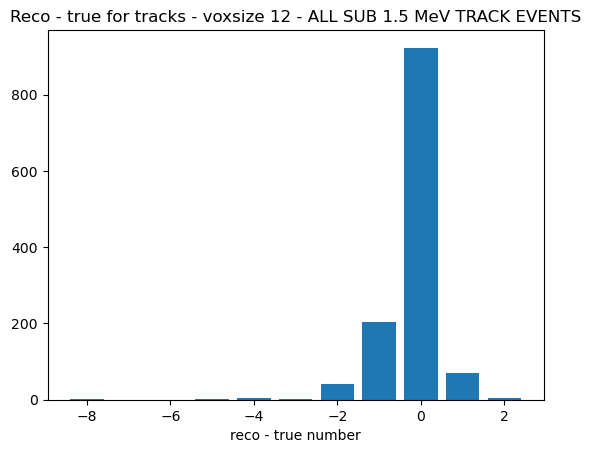

In [44]:
df = pd.read_pickle('true_reco_v12.h5')
labels, counts = np.unique(df['reco-true'], return_counts=True)
plt.bar(labels, counts, align = 'center')
plt.title('Reco - true for tracks - voxsize 12 - ALL SUB 1.5 MeV TRACK EVENTS')
plt.xlabel('reco - true number')
plt.show()

Text(0.5, 0, 'reco - true')

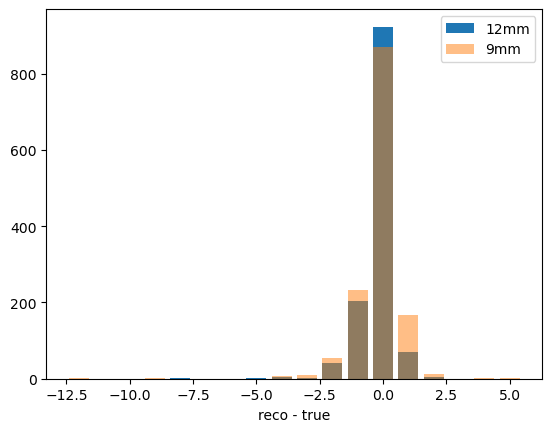

In [45]:
df = pd.read_pickle('true_reco_v12.h5')
labels, counts = np.unique(df['reco-true'], return_counts=True)
plt.bar(labels, counts, align = 'center', label = '12mm')

df = pd.read_pickle('true_reco_v9.h5')
labels, counts = np.unique(df['reco-true'], return_counts=True)
plt.bar(labels, counts, align = 'center', label = '9mm', alpha = 0.5)
plt.legend()
plt.xlabel('reco - true')